<a href="https://colab.research.google.com/github/namanverma4321/Face_Detection_using_Computer_Vision/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Folder_for_Face_Recognition/
# !ls

/content/drive/MyDrive/Folder_for_Face_Recognition


###Import essential libraries

In [3]:
from PIL import Image
import os
import re
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage.feature import hog

###Obtain image feature & label

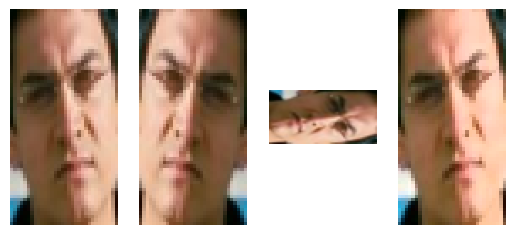

4

In [4]:
# Data augmentation parameters
flip_horizontal = True       # Flip horizontally
brightness_factor = 0.2      # Change brightness by a factor of 0.2

def apply_data_augmentation(img):
    augmented_images = [img]

    if flip_horizontal:
        # Augmentation 1: Horizontal Flip
        flipped_img = cv2.flip(img, 1)  # Flip horizontally
        augmented_images.append(flipped_img)


    # Augmentation 2: Rotation
    rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)  # Rotate 30 degrees clockwise
    augmented_images.append(rotated_img)

    # Augmentation 3: Brightness adjustment
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v = v.astype(float)
    v *= (1.0 + brightness_factor)  # Increase brightness
    v = np.clip(v, 0, 255)
    v = v.astype(np.uint8)
    hsv = cv2.merge((h, s, v))
    img_brightened = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    augmented_images.append(img_brightened)

    return augmented_images
img = Image.open(os.path.join('TrainingPhotos/', 'Amir_122.jpg'))  # open image
img = img.resize([32, 64])  # resize image to a fixed size
count=0
# Apply data augmentation
augmented_images = apply_data_augmentation(np.array(img))

for i, augmented_image in enumerate(augmented_images):
    plt.subplot(1, len(augmented_images), i+1)  # Create subplots for each image
    plt.imshow(augmented_image)
    plt.axis('off')  # Turn off axis labels and ticks
    count+=1
plt.show()  # Display all the images
count

In [5]:

folder = 'TrainingPhotos/'  # location of training images
X = []
Y = []

for filename in os.listdir(folder):
    img = Image.open(os.path.join(folder, filename))  # open image
    img = img.resize([32, 64])  # resize image to a fixed size

    # Apply data augmentation
    augmented_images = apply_data_augmentation(np.array(img))

    for augmented_img in augmented_images:
        fd, hog_image = hog(augmented_img, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True, multichannel=True)  # obtain HOG features
        X.append(fd)

        # Obtain training labels from file name
        if re.match("Amir*", filename):
            Yt = 0
        elif re.match("Jaya*", filename):
            Yt = 1
        elif re.match("Hir*", filename):
            Yt = 2
        elif re.match("Anupam*", filename):
            Yt = 3
        else:
            Yt = 4
        Y.append(Yt)

<ipython-input-5-69872ddcc8fa>:13: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(augmented_img, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True, multichannel=True)  # obtain HOG features


In [6]:
fd.shape

(3780,)

In [7]:
target_names=['AamirKhan', 'JayaBadhuri', 'HritikRoshan', 'AnupamKher']

###Split data into training/test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

###Reduce dimenions with PCA

In [9]:
n_components = 25
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

In [10]:
# project training and test data to lower dimension
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [11]:
# Save PCA coefficients for use at prediction

import pickle as pk
pk.dump(pca, open("PCA.pkl","wb"))

###Train SVM classifier

In [12]:
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced',probability=True), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.1, probability=True)


In [13]:
# Save best SVM classifier weights for use at prediction

import joblib
joblib.dump(clf.best_estimator_, 'SVM_classifier.pkl', compress = 1) # Only best parameters

['SVM_classifier.pkl']

###Model performance on test set

In [14]:
y_pred = clf.predict(X_test_pca)
y_pred

array([1, 2, 2, 1, 1, 2, 0, 1, 1, 2, 0, 3, 0, 0, 1, 0, 0, 1, 0, 2, 0, 2,
       0, 0, 0, 2, 2, 0, 1, 0, 0, 3, 1, 2, 0, 0, 0, 0, 3, 1, 1, 1, 0, 0,
       1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 1, 0, 2, 0, 0, 0, 2, 1, 0, 2, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 0, 2, 1, 2, 1, 2, 0,
       1, 1, 1, 2, 1, 3, 0, 2, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 3, 0, 1, 0, 0, 2, 0, 2, 0, 1, 2, 0, 2, 1, 1,
       2, 0, 1, 2, 3, 2, 1, 0, 0, 0, 0, 2, 0, 0, 1, 3, 0, 1, 3, 0, 2, 1,
       3, 0, 0, 3, 1, 3, 0, 1, 2, 2, 0, 0, 1, 2, 1, 0, 2, 2, 0, 1, 2, 1,
       0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 3, 2, 2, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0, 3, 1, 1, 2, 1, 0, 0, 1, 0, 1,
       0, 3, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1, 0, 3, 0, 1, 0, 1, 1,
       3, 0, 2, 0, 1, 3, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 2, 1,
       1, 2, 1, 1, 0, 0, 3, 0, 0, 2, 0, 2, 1, 1, 2, 0, 0, 0, 0, 2, 3, 1,
       0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 0, 0,

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85       168
           1       0.96      0.90      0.93       131
           2       0.74      0.75      0.75        84
           3       0.90      0.64      0.75        42

    accuracy                           0.84       425
   macro avg       0.85      0.80      0.82       425
weighted avg       0.85      0.84      0.84       425

